# Classificazione dell'abitabilità degli exoplanets


Confronto tra diversi *modelli di apprendimento supervisionato* per la classificazione di esopianeti scoperti durante le diverse missioni spaziali.

L'obbiettivo è sicuramente quello di trovare il migliore modello di classifficazione in grado di deteminare la classe di abitibilità dell'esopianeta sottoposto al modello, sebbene i dati a nostra disposizione non sono sicuramente dei migliori.

Questo sistema inoltre si pone come modulo complementare al sistema più ampio progettato per l'esame di ingeneria della conoscenza, il quale permetterà di agire anche con un sistema esperto.

I modelli valutati in questo modulo sono i seguenti:
- **Decision**
- **Naive Bayes**
- **Random Forest**
- **Gradiend Boost**
- **Support vector machine**

Importo i moduli e le librerie di interesse, utili per la realizzazione del sistema.

In [379]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve



from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from imblearn.metrics import geometric_mean_score




## Analisi Esplorativa & Preparazione dei Dati

Carichiamo il dataset in locale.

In [380]:
planets = pd.read_csv("../PHL-EC.csv")
planets.head()

,P. Name,P. Name Kepler,P. Name KOI,P. Zone Class,P. Mass Class,P. Composition Class,P. Atmosphere Class,P. Habitable Class,P. Min Mass (EU),P. Mass (EU),P. Max Mass (EU),P. Radius (EU),P. Density (EU),P. Gravity (EU),P. Esc Vel (EU),P. SFlux Min (EU),P. SFlux Mean (EU),P. SFlux Max (EU),P. Teq Min (K),P. Teq Mean (K),P. Teq Max (K),P. Ts Min (K),P. Ts Mean (K),P. Ts Max (K),P. Surf Press (EU),P. Mag,P. Appar Size (deg),P. Period (days),P. Sem Major Axis (AU),P. Eccentricity,P. Mean Distance (AU),P. Inclination (deg),P. Omega (deg),S. Name,S. Name HD,S. Name HIP,S. Constellation,S. Type,S. Mass (SU),S. Radius (SU),S. Teff (K),S. Luminosity (SU),S. [Fe/H],S. Age (Gyrs),S. Appar Mag,S. Distance (pc),S. RA (hrs),S. DEC (deg),S. Mag from Planet,S. Size from Planet (deg),S. No. Planets,S. No. Planets HZ,S. Hab Zone Min (AU),S. Hab Zone Max (AU),P. HZD,P. HZC,P. HZA,P. HZI,P. SPH,P. Int ESI,P. Surf ESI,P. ESI,S. HabCat,P. Habitable,P. Hab Moon,P. Confirmed,P. Disc. Method,P. Disc. Year,Unnamed: 68
0,1RXS 1609 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,4451.16,NaN,19.04,0.64,12.28,15.29,4.08E-06,4.08E-06,4.08E-06,11.4,11.4,11.4,NaN,NaN,NaN,2870.4,-10.06,36.81,NaN,330.0,0.0,330.0,NaN,0.0,1RXS1609,NaN,NaN,Sco,K7V,0.73,1.35,4060.0,0.444285,NaN,0.011,NaN,145.0,16.1583,-21.0828,-13.2,0.0022,1,0,0.540,1.362,800.07,23.51,85.62,0.00,NaN,0,0,0.05,0,0,0,1,Imaging,2008,NaN
1,1SWASP J1407 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,6358.80,6358.80,NaN,10.94,4.86,53.12,24.11,0.02166914,0.02166914,0.02166914,97.7,97.7,97.7,NaN,NaN,NaN,30873.8,-18.21,20.91,3725.0,3.9,0.0,3.9,NaN,0.0,1SWASP J1407,NaN,NaN,Cen,K,0.90,0.99,4400.0,0.329588,NaN,0.016,12.4,133.0,14.1300,-39.7619,-22.5,0.1353,1,0,0.461,1.143,9.07,15.30,45.41,0.02,NaN,0,0,0.07,0,0,0,1,Primary Transit,2012,NaN
2,2M 0103-55(AB) b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,4133.22,4133.22,NaN,11.40,2.79,31.79,19.04,3.96E-06,3.96E-06,3.96E-06,11.4,11.4,11.4,NaN,NaN,NaN,11520.8,-8.91,21.80,NaN,84.0,0.0,84.0,NaN,0.0,2M 0103-55(AB),NaN,NaN,Phe,M,0.40,0.38,3840.0,0.027955,NaN,0.030,NaN,47.2,1.0600,-55.2656,-13.2,0.0024,1,0,0.136,0.347,793.67,12.57,107.44,0.00,NaN,0,0,0.06,0,0,0,1,Imaging,2013,NaN
3,2M 0122-24 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,6358.80,NaN,11.20,4.53,50.69,23.83,1.03E-05,1.03E-05,1.03E-05,14.4,14.4,14.4,NaN,NaN,NaN,28780.4,-9.92,21.41,NaN,52.0,0.0,52.0,NaN,0.0,2M 0122-24,NaN,NaN,Cet,M3.5,0.40,0.38,3840.0,0.027955,NaN,0.120,NaN,36.0,1.3808,-24.6142,-14.2,0.0039,1,0,0.136,0.347,490.45,15.72,119.46,0.00,NaN,0,0,0.08,0,0,0,1,Imaging,2013,NaN
4,2M 0219-39 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,4419.37,NaN,16.13,1.05,16.99,16.55,2.37E-07,2.37E-07,2.37E-07,5.6,5.6,5.6,NaN,NaN,NaN,4655.6,-6.60,31.03,NaN,156.0,0.0,156.0,NaN,0.0,2M 0219-39,NaN,NaN,For,M6,0.11,0.27,3064.0,0.005765,NaN,NaN,NaN,39.4,2.3228,-39.4231,-10.1,0.0009,1,0,0.062,0.165,3028.82,19.46,133.25,0.00,NaN,0,0,0.06,0,0,0,1,Imaging,2015,NaN


### Pulizia dei dati

Verichiamo quanti esempi sono presenti per ogni classe di abitibilità.


In [381]:
# mi faccio una idea idea su quali siano le tipologie di pianeti con meno esempi

target_count = planets['P. Habitable Class'].value_counts()
target_count

non-habitable        3820
mesoplanet             31
psychroplanet          18
hypopsychroplanet       3
thermoplanet            3
Name: P. Habitable Class, dtype: int64

Eliminiamo le tipologie di pianeti per i quali abbiamo pochi esempi.

In [382]:
# elimino effettivamente i pianeti appartenenyi alla classe dei 'thermoplanet' e 'hypopsychroplanet'
# per i quali abbiamo solamente 3 esempi ciscuno

indexNames = planets[planets['P. Habitable Class'] == 'thermoplanet'].index
planets.drop(indexNames, inplace= True)


indexNames = planets[planets['P. Habitable Class'] == 'hypopsychroplanet'].index
planets.drop(indexNames, inplace= True)

Dopo l'eliminazione delle classi con pochi esempi avremo la seguente situazione; le classi di abitabilità non saranno più 5 ma saranno ridotte a 3 classi di abitabilita:
+ **non-habitable**
+ **mesoplanet**
+ **psychroplanet**

In [383]:
# ora la situazione sarà la seguente

target_count = planets['P. Habitable Class'].value_counts()
target_count

non-habitable    3820
mesoplanet         31
psychroplanet      18
Name: P. Habitable Class, dtype: int64

Avendo eliminato degli esempi, ossia delle righe dal nostro dataframe devo resettare di conseguenza l'index.

In [384]:
# resetto l'index del nostro database che è cambiato avendo tolto alcuni esempi

planets.reset_index(inplace = True, drop= True)

Continuamo rimuovendo ulteriori features in input, in modo tale da ridurre la dimensionalità del feautures space e in modo tale da rimuovere quelle features per le quali si hanno pochi dati.

In [385]:
# funzione che permette di rimuovere le feutures la cui densità è sotto un certo treshold
# count = valori nulli in una colonna specifica(in una feature)
# lenplanet(planet) = numero di righe totali(tot pianeti)
# count/len(planet) = ci dice in percentuale quanti valori ci saranno in quella colonna

def remove_missing(feauture):
    count = len(planets[planets[feauture].isnull()])
    if count/len(planets) > 0.2:
        return 1
    else:
        return 0
    
missing_values = [x for x in planets.columns if remove_missing(x)]
planets = planets.drop(missing_values, axis=1)

Rimuoviamo anche le seguenti features che non hanno alcuna valenza per il nostro obbiettivo: alcune di esse rappresentano l'incertezza di certe features, altre non hanno valenza da un punto di vista fisico.

In [386]:
# rimuovo altre features che rappresentano l'incertezza di alcune feautures e
# altre feautures che non interessano direttamente la classificazione

cols_to_drop = ['P. Name','S. Constellation', 'S. Type', 'P. Int ESI', 'P. Habitable',
                'P. Surf ESI', 'P. Disc. Method', 'P. Disc. Year','P. Hab Moon', 'P. SFlux Min (EU)', 'P. SFlux Max (EU)',
                'P. Teq Min (K)','P. Teq Max (K)','P. SFlux Mean (EU)','S. Name', 'S. Hab Zone Min (AU)', 'S. Hab Zone Max (AU)']

planets = planets.drop(cols_to_drop, axis=1)

Le features rimaste per il momento saranno pertanto le seguenti.

In [387]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

print(planets.columns.tolist())


['P. Zone Class', 'P. Mass Class', 'P. Composition Class', 'P. Atmosphere Class', 'P. Habitable Class', 'P. Mass (EU)', 'P. Radius (EU)', 'P. Density (EU)', 'P. Gravity (EU)', 'P. Esc Vel (EU)', 'P. Teq Mean (K)', 'P. Surf Press (EU)', 'P. Mag', 'P. Appar Size (deg)', 'P. Period (days)', 'P. Sem Major Axis (AU)', 'P. Eccentricity', 'P. Mean Distance (AU)', 'P. Omega (deg)', 'S. Mass (SU)', 'S. Radius (SU)', 'S. Teff (K)', 'S. Luminosity (SU)', 'S. RA (hrs)', 'S. DEC (deg)', 'S. Mag from Planet', 'S. Size from Planet (deg)', 'S. No. Planets', 'S. No. Planets HZ', 'P. HZD', 'P. HZC', 'P. HZA', 'P. HZI', 'P. ESI', 'S. HabCat', 'P. Confirmed']


Per decidere se eliminare altre features osserviamo la correlazione tra le feutures creando una visualizzazione che traccia la misura di correlazione per ogni feature nel set di dati.

Prima di poter fare questo però devo :
1. *riempire il dataset con dati mancanti*
2. *trasformare le features categoriche in features numeriche*


Prima di tutto determiniamoo quali siano le features categoriche

In [388]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
print(planets.dtypes.tolist)

<bound method IndexOpsMixin.tolist of P. Zone Class                 object
P. Mass Class                 object
P. Composition Class          object
P. Atmosphere Class           object
P. Habitable Class            object
P. Mass (EU)                 float64
P. Radius (EU)               float64
P. Density (EU)              float64
P. Gravity (EU)              float64
P. Esc Vel (EU)              float64
P. Teq Mean (K)              float64
P. Surf Press (EU)           float64
P. Mag                       float64
P. Appar Size (deg)          float64
P. Period (days)             float64
P. Sem Major Axis (AU)       float64
P. Eccentricity              float64
P. Mean Distance (AU)        float64
P. Omega (deg)               float64
S. Mass (SU)                 float64
S. Radius (SU)               float64
S. Teff (K)                  float64
S. Luminosity (SU)           float64
S. RA (hrs)                  float64
S. DEC (deg)                 float64
S. Mag from Planet           float64


Si noti come le uniche features categoriche siano le prime 5:

1. *P. Zone Class*
2. *P. Mass Class*
3. *P. Composition Class*
4. *P. Atmosphere Class*
5. *P. Habitable Class'*


Verifichiamo quanti siano i dati mancanti in totale, considerando quindi sia le features categoriche che quelle numeriche.
Sfruttiamo inoltre un heatmap per facilitare la lettura di tali valori.


P. Zone Class                 46
P. Mass Class                  6
P. Composition Class          41
P. Atmosphere Class           85
P. Habitable Class             0
P. Mass (EU)                  33
P. Radius (EU)                12
P. Density (EU)               41
P. Gravity (EU)               41
P. Esc Vel (EU)               41
P. Teq Mean (K)               46
P. Surf Press (EU)            41
P. Mag                        56
P. Appar Size (deg)           12
P. Period (days)             150
P. Sem Major Axis (AU)        35
P. Eccentricity                0
P. Mean Distance (AU)         35
P. Omega (deg)                 0
S. Mass (SU)                  47
S. Radius (SU)               112
S. Teff (K)                   99
S. Luminosity (SU)            28
S. RA (hrs)                    0
S. DEC (deg)                   0
S. Mag from Planet            46
S. Size from Planet (deg)    128
S. No. Planets                 0
S. No. Planets HZ              0
P. HZD                        46
P. HZC    

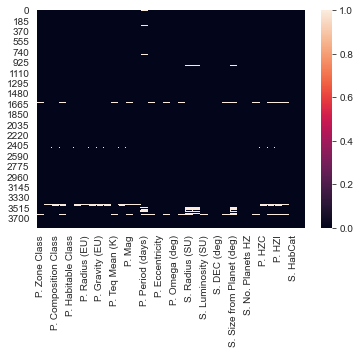

In [389]:
print(planets.isnull().sum())
sns.heatmap(planets.isnull())

##### FASE 1 : riempire il dataset con dati mancanti

Per le features numeriche adottiamo il **simple Imputer di sklearn** che permette di riempire il valore mancante con il valore medio all'interno della colonna, specificando come strategia *mean*

In [390]:
# inserisco le features numeriche in una lista
numeric_features = list(planets[planets._get_numeric_data().columns])

simple_inputer = SimpleImputer(missing_values=np.nan, strategy='mean')
planets[numeric_features] = simple_inputer.fit_transform(planets[numeric_features])

planets[numeric_features].isnull().sum()

P. Mass (EU)                 0
P. Radius (EU)               0
P. Density (EU)              0
P. Gravity (EU)              0
P. Esc Vel (EU)              0
P. Teq Mean (K)              0
P. Surf Press (EU)           0
P. Mag                       0
P. Appar Size (deg)          0
P. Period (days)             0
P. Sem Major Axis (AU)       0
P. Eccentricity              0
P. Mean Distance (AU)        0
P. Omega (deg)               0
S. Mass (SU)                 0
S. Radius (SU)               0
S. Teff (K)                  0
S. Luminosity (SU)           0
S. RA (hrs)                  0
S. DEC (deg)                 0
S. Mag from Planet           0
S. Size from Planet (deg)    0
S. No. Planets               0
S. No. Planets HZ            0
P. HZD                       0
P. HZC                       0
P. HZA                       0
P. HZI                       0
P. ESI                       0
S. HabCat                    0
P. Confirmed                 0
dtype: int64

Per le features categoriche adottiamo il **simple Imputer di sklearn** che permette di riempire il valore mancante con quello più ricorrente all'interno della colonna, specificando come strategia *most frequent*

In [391]:
# inserisco le features categoriche in una lista
categorical_features = [col for col in planets.columns if planets[col].dtype=="O"]

simple_inputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
planets[categorical_features] = simple_inputer.fit_transform(planets[categorical_features])

planets[categorical_features].isnull().sum()


P. Zone Class           0
P. Mass Class           0
P. Composition Class    0
P. Atmosphere Class     0
P. Habitable Class      0
dtype: int64

Il risultato finale sarà il seguente.


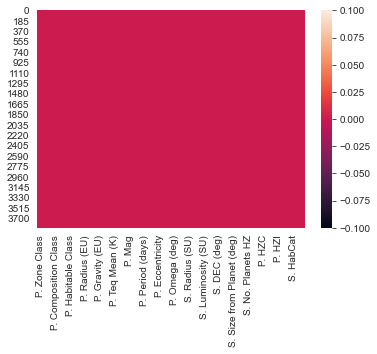

In [392]:
sns.heatmap(planets.isnull())

##### FASE 2 : trasformare le feauture categoriche in feauturs numeriche

Le prime 3 features (*P. Zone Class, P. Mass Class, new P. Habitable Class*) verranno trasformate utilizzando il **label encoding**, essendoci effettivamente un ordine tra i values le features. 

In [393]:
ord_enc = OrdinalEncoder()
planets["new P. Zone Class_code"] = ord_enc.fit_transform(planets[["P. Zone Class"]])

planets["new P. Mass Class"] = ord_enc.fit_transform(planets[["P. Mass Class"]])

planets["new P. Habitable Class"] = ord_enc.fit_transform(planets[["P. Habitable Class"]])



Poichè si è scoperto che stratifiedKFold non funziona con le feututres target multilabel ossia con le variabili indicatrici
si è deciso di optare per il label encoding sebbene questa non sia stata la prima scelta.

*Errore uscito : 'Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead'*



Le altre due features (*P. Composition Class, P. Atmosphere Class)* verranno traformate utilizzando **l'hot encoder** che crea nuove feutures booleane a partire dai values delle features, ossia crea le *variabili indicatrici*


In [394]:
# Il punto chiave è che devi utilizzare toarray() per convertire i risultati in un 
# formato che può essere convertito in un DataFrame.

# traformazione feature P. Composition Class
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(planets[["P. Composition Class"]])
pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)

# Il passaggio successivo è unire questi dati al dataframe originale.
planets = planets.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

# traformazione feature P. Atmosphere Class
oe_results = oe_style.fit_transform(planets[["P. Atmosphere Class"]])
pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)

planets = planets.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))


# NON FUNZIONA LEGGERE SOPRA(blocco markdown sotto il blocco 67)
#  traformazione feature P. Habitable Class
#oe_results = oe_style.fit_transform(planets[["P. Habitable Class"]])
#pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)

#planets = planets.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

Il dataframe con le nuove features sarà il seguente

In [395]:
planets.head()

,P. Zone Class,P. Mass Class,P. Composition Class,P. Atmosphere Class,P. Habitable Class,P. Mass (EU),P. Radius (EU),P. Density (EU),P. Gravity (EU),P. Esc Vel (EU),P. Teq Mean (K),P. Surf Press (EU),P. Mag,P. Appar Size (deg),P. Period (days),P. Sem Major Axis (AU),P. Eccentricity,P. Mean Distance (AU),P. Omega (deg),S. Mass (SU),S. Radius (SU),S. Teff (K),S. Luminosity (SU),S. RA (hrs),S. DEC (deg),S. Mag from Planet,S. Size from Planet (deg),S. No. Planets,S. No. Planets HZ,P. HZD,P. HZC,P. HZA,P. HZI,P. ESI,S. HabCat,P. Confirmed,new P. Zone Class_code,new P. Mass Class,new P. Habitable Class,"(gas,)","(iron,)","(rocky-iron,)","(rocky-water,)","(water-gas,)","(hydrogen-rich,)","(metals-rich,)","(no-atmosphere,)"
0,Cold,Jovian,gas,hydrogen-rich,non-habitable,4451.16,19.04,0.64,12.28,15.29,11.4,2870.4,-10.06,36.81,721.574617,330.0,0.0,330.0,0.0,0.73,1.35,4060.0,0.444285,16.1583,-21.0828,-13.2,0.0022,1.0,0.0,800.07,23.51,85.62,0.00,0.05,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Cold,Jovian,gas,hydrogen-rich,non-habitable,6358.80,10.94,4.86,53.12,24.11,97.7,30873.8,-18.21,20.91,3725.000000,3.9,0.0,3.9,0.0,0.90,0.99,4400.0,0.329588,14.1300,-39.7619,-22.5,0.1353,1.0,0.0,9.07,15.30,45.41,0.02,0.07,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Cold,Jovian,gas,hydrogen-rich,non-habitable,4133.22,11.40,2.79,31.79,19.04,11.4,11520.8,-8.91,21.80,721.574617,84.0,0.0,84.0,0.0,0.40,0.38,3840.0,0.027955,1.0600,-55.2656,-13.2,0.0024,1.0,0.0,793.67,12.57,107.44,0.00,0.06,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Cold,Jovian,gas,hydrogen-rich,non-habitable,6358.80,11.20,4.53,50.69,23.83,14.4,28780.4,-9.92,21.41,721.574617,52.0,0.0,52.0,0.0,0.40,0.38,3840.0,0.027955,1.3808,-24.6142,-14.2,0.0039,1.0,0.0,490.45,15.72,119.46,0.00,0.08,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Cold,Jovian,gas,hydrogen-rich,non-habitable,4419.37,16.13,1.05,16.99,16.55,5.6,4655.6,-6.60,31.03,721.574617,156.0,0.0,156.0,0.0,0.11,0.27,3064.0,0.005765,2.3228,-39.4231,-10.1,0.0009,1.0,0.0,3028.82,19.46,133.25,0.00,0.06,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Rinomiano il label delle nuove features create.


In [396]:
planets.rename({('gas',): 'Composition gas', 
                ('iron',): 'Composition iron',
                ('rocky-iron',): 'Composition rocky-iron', 
                ('rocky-water',): 'Composition rocky-water',
                ('water-gas',): 'Composition water-gas'}, axis=1, inplace= True) 

planets.rename({('hydrogen-rich',): 'Atmosphere hydrogen-rich', 
                ('metals-rich',): 'Atmosphere metals-rich',
                ('no-atmosphere',): 'Atmosphere no-atmosphere'}, axis=1, inplace= True) 

# NON FUNZIONA LEGGERE SOPRA(blocco markdown sotto il blocco 67)
#planets.rename({('mesoplanet',): 'Habitable mesoplanet', 
                # ('non-habitable',): 'Habitable non-habitable',
                # ('psychroplanet',): 'Habitable psychroplanet'}, axis=1, inplace= True) 


Osserviamo la correlazione

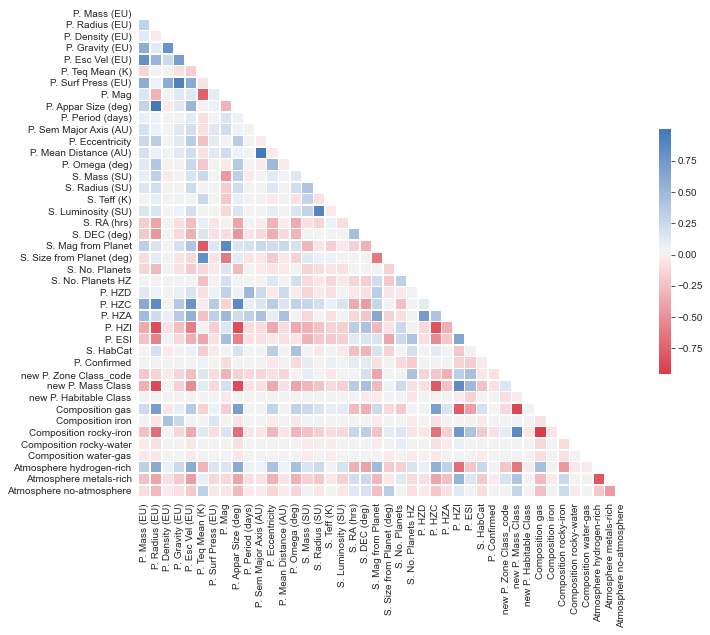

In [397]:
# pands .corr() per calcolare la correlazione a coppie tra le features del dataframes
corr = planets.corr()

# visualizzo i dati con seaborn
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Si noti come tra le features rimaste ci siano delle feautures altamente correlate tra di loro, che restituiscono sostanzialmente le stesse informazioni, pertanto le rimuoviamo:

- **P. Mass Class ---> P. Radius (EU) and P. Mass (EU)**
- **P. Appar Size  ---> P. Radius (EU)**
- **P. Surf Press    ---> Gravity**
- **S. Mag from Planet ---> P. Mag**
- **P. Sem Major Axis(AU) ---> P. Mean Distance(AU)**
- **S. Size from Planet(deg) -->S. Mag from Planet**
- **P. HZC --> P.Composition Class**
- **P. HZA --> P Atmoshere Class**
- **P. HZI --> HZD and HZC and HZA**

Sebbene non sia altamente evidenziata la seguente correlazione, la rimuoviamo perchè sono correlate da un punto di vista fisico:
- **P. Zone Class ---> HZD** 

La veridicità di tutte le precedenti correlazioni è state inoltre confermata da ricerce esplorative sul web.



In [398]:
cols_to_drop = ["P. Mass Class", "P. Zone Class", "P. Appar Size (deg)", "P. Surf Press (EU)", "S. Mag from Planet", "P. Sem Major Axis (AU)", "S. Size from Planet (deg)", "P. HZC", "P. HZA", "P. HZI"]

planets = planets.drop(cols_to_drop, axis=1)

Possiamo ora notare come il nostro dataset sia molto sbilanciato

non-habitable: 3820
mesoplanet: 31
psychroplanet : 18
Percentage of Majority Class: 98.72999999999999
Percentage of Minority Class: 0.8
Percentage of Minority Class: 0.47000000000000003


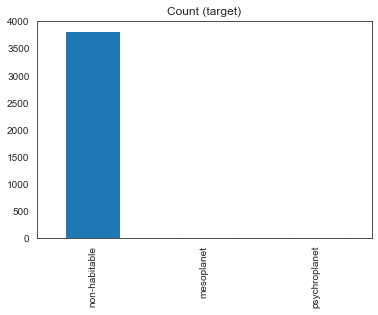

In [399]:
target_count = planets['P. Habitable Class'].value_counts()
print(f'non-habitable: {target_count[0]}')
print(f'mesoplanet: {target_count[1]}')
print(f'psychroplanet : {target_count[2]}')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')
print(f'Percentage of Minority Class: {round(target_count[1] / sum(target_count), 4)*100}')
print(f'Percentage of Minority Class: {round(target_count[2] / sum(target_count), 4)*100}')

target_count.plot(kind='bar', title='Count (target)')

In [400]:
planets.head()

,P. Composition Class,P. Atmosphere Class,P. Habitable Class,P. Mass (EU),P. Radius (EU),P. Density (EU),P. Gravity (EU),P. Esc Vel (EU),P. Teq Mean (K),P. Mag,P. Period (days),P. Eccentricity,P. Mean Distance (AU),P. Omega (deg),S. Mass (SU),S. Radius (SU),S. Teff (K),S. Luminosity (SU),S. RA (hrs),S. DEC (deg),S. No. Planets,S. No. Planets HZ,P. HZD,P. ESI,S. HabCat,P. Confirmed,new P. Zone Class_code,new P. Mass Class,new P. Habitable Class,Composition gas,Composition iron,Composition rocky-iron,Composition rocky-water,Composition water-gas,Atmosphere hydrogen-rich,Atmosphere metals-rich,Atmosphere no-atmosphere
0,gas,hydrogen-rich,non-habitable,4451.16,19.04,0.64,12.28,15.29,11.4,-10.06,721.574617,0.0,330.0,0.0,0.73,1.35,4060.0,0.444285,16.1583,-21.0828,1.0,0.0,800.07,0.05,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,gas,hydrogen-rich,non-habitable,6358.80,10.94,4.86,53.12,24.11,97.7,-18.21,3725.000000,0.0,3.9,0.0,0.90,0.99,4400.0,0.329588,14.1300,-39.7619,1.0,0.0,9.07,0.07,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,gas,hydrogen-rich,non-habitable,4133.22,11.40,2.79,31.79,19.04,11.4,-8.91,721.574617,0.0,84.0,0.0,0.40,0.38,3840.0,0.027955,1.0600,-55.2656,1.0,0.0,793.67,0.06,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,gas,hydrogen-rich,non-habitable,6358.80,11.20,4.53,50.69,23.83,14.4,-9.92,721.574617,0.0,52.0,0.0,0.40,0.38,3840.0,0.027955,1.3808,-24.6142,1.0,0.0,490.45,0.08,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,gas,hydrogen-rich,non-habitable,4419.37,16.13,1.05,16.99,16.55,5.6,-6.60,721.574617,0.0,156.0,0.0,0.11,0.27,3064.0,0.005765,2.3228,-39.4231,1.0,0.0,3028.82,0.06,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Divisione del Dataset

Dividiamo il dataset in set training e set di test

In [401]:
# TODO fare una copia forse
cols_to_drop = ["P. Composition Class", "P. Atmosphere Class","P. Habitable Class"]

planets = planets.drop(cols_to_drop, axis=1)

In [402]:
target_features = ['new P. Habitable Class']

# X: set di samples con le input features
# y: set di samples con la target feature

X = planets.drop(target_features, axis=1)
y = planets[target_features]



In [403]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=11)


## Costruzione dei modelli & Addestramento

### Classificazione con  DecisionTreeClassifier

Creiamo un pipeline dove vengono svolte in maniere consequenziale le seguenti azioni:

1. SMOTE  un'operazione di l'oversampling sul set di training
2. Scaler un'operazione di normalizzazione
3. Classifier è definito il modello che verrà utilizzito per l'apprendimento, in questo caso il Decision Tree Classifier

In [404]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', DecisionTreeClassifier(random_state=11)]])

Creiamo un'istanza della classe **StratifiedKFold** che ci permette di andare a definire un tipo di Cross Validation

In [405]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12)

Definiamo l'insieme degli iper-parametri, su cui verrà effettuato un tuning durante la fase di test.

Definiamo anche un'istanza di **GridSearchCV**, che ci permetterà ci combinare la cross validation con la pipeline.

In [406]:

# in param_grid sono definiti gli iperparametri
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(1,10),
    'min_samples_split':range(2,10),
    'min_samples_leaf':range(1,5)    
}
new_params = {'classifier__' + key: param_grid[key] for key in param_grid}


# permette di provare tutte le combinazioni degli iper parametri in modo tale da ottenre 
# i valori ottimali per il modello
# quindi itera per ogni fold creata sugli iperparametri 
# Niper = numero iper paratri                   
# Nfold = numero fold
# Viper = values per ogni per parametro

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

Adattiamo il nostro modello di training sul set di training e runniamo la funzione **grid_search.fit**, al termine della quale otterremo il modello migliore.

Passiamo in seguito alla fase di test e prediciamo le classi di abitabilità sui campioni X_test.

In [407]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')
# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)


Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 4}
Cross-validation score: 0.997415080815144


Valutiamo il modello sulle seguenti metriche:
- accuracy
- recall
- precision
- f1
- matthews correlation coefficent
- geometric mean score


accuracy: 0.9948320413436692
precision: 0.75
recall: 0.8324607329842931
f1: 0.7852774137177807
matthews_corrcoef: 0.8197002684542365
geometric_mean_score: 0.9116015388298121


[]

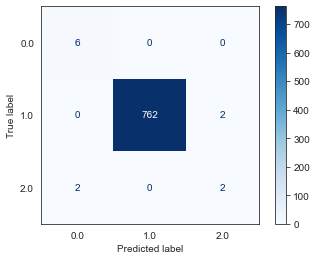

In [408]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()



In [409]:
scoring_list = []
scoring_list.append(dict([
    ('Model', 'DecisionTreeClassifier'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

### Classificazione con  Naive Bayes

In [410]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', GaussianNB()]]) 

In [411]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12)

Non avendo questo modello degli iper-parametri l'insieme dei parametri sarà vuoto.

In [412]:
# in param_grid sono definiti gli iperparametri
param_grid = {}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [413]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


accuracy: 0.9922480620155039
precision: 0.6944444444444445
recall: 0.831588132635253
f1: 0.7515060617422823
matthews_corrcoef: 0.7579632427016252
geometric_mean_score: 0.9107284383867313


[]

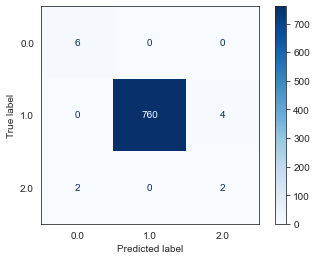

In [414]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [415]:
scoring_list.append(dict([
    ('Model', 'Naive Bayes'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

### Classificazione con  RandomForest

In [416]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', RandomForestClassifier(max_depth=None, random_state=None)]]) #decidete se mettere qualche parametro

In [417]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12)

In [418]:
# in param_grid sono definiti gli iperparametri
param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [4, 6, 10, 12],
                }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [419]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'classifier__max_depth': 4, 'classifier__n_estimators': 50}
Cross-validation score: 0.9983843863487696


accuracy: 0.9987080103359173
precision: 0.9523809523809524
recall: 0.9166666666666666
f1: 0.9267399267399267
matthews_corrcoef: 0.9495595614242498
geometric_mean_score: 0.9572193102264341


[]

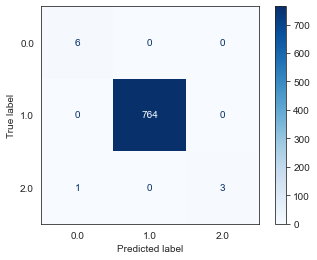

In [420]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [421]:
scoring_list.append(dict([
    ('Model', 'RandomForest'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

### Classificazione con Gradient Boosting

In [422]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier',GradientBoostingClassifier(n_estimators=100,
                                                                         learning_rate=1.0,
                                                                         max_depth=1, 
                                                                         random_state=11)]]) #decidete se mettere qualche parametro

In [423]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12)

In [424]:
# in param_grid sono definiti gli iperparametri
param_grid = {   
              'max_depth': range (2, 10, 1),
              'n_estimators': range(60, 220, 40),
              'learning_rate': [0.1, 0.01, 0.05]
              }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

# TODO verificare per quale motivo non funzionano le altre metriche
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [425]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best parameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 100}
Cross-validation score: 0.9980617022183124


accuracy: 0.9974160206718347
precision: 0.9166666666666666
recall: 0.9162303664921465
f1: 0.904543611812767
matthews_corrcoef: 0.9049164998345826
geometric_mean_score: 0.9567836890501136


[]

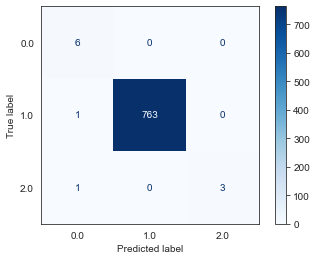

In [426]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [427]:
scoring_list.append(dict([
    ('Model', 'Gradient Boosting'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

### Classificazione con SVM

In [428]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier',SVC(kernel=None,
                                                  gamma=None, 
                                                  C=None)]]) #decidete se mettere qualche parametro cambiare parametri con iper parametri

In [429]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [430]:
# in param_grid sono definiti gli iperparametri
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
              }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [431]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters: {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Cross-validation score: 0.9964457752815185


accuracy: 0.9961240310077519
precision: 0.8888888888888888
recall: 0.75
f1: 0.7333333333333334
matthews_corrcoef: 0.8489522782601875
geometric_mean_score: 0.8654614015078893


[]

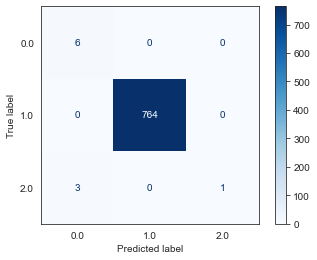

In [432]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [433]:
scoring_list.append(dict([
    ('Model', 'SVM'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))


## Confronto Riassuntivo

Ora confrontiamo i vari modelli secondo le metriche usate


In [434]:
results = pd.DataFrame(data=scoring_list)
results = results[['Model',
                   'Train Accuracy',
                   'Test Accuracy',
                   'Precision',
                   'Recall',
                   'F1',
                   'Matthews Corrcoef',
                   'Geometric Mean Score']]

results = results.sort_values(by='Recall', ascending=False)

results


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1,Matthews Corrcoef,Geometric Mean Score
2,RandomForest,0.998,0.999,0.952,0.917,0.927,0.950,0.957
3,Gradient Boosting,0.998,0.997,0.917,0.916,0.905,0.905,0.957
0,DecisionTreeClassifier,0.997,0.995,0.750,0.832,0.785,0.820,0.912
1,Naive Bayes,0.991,0.992,0.694,0.832,0.752,0.758,0.911
4,SVM,0.996,0.996,0.889,0.750,0.733,0.849,0.865


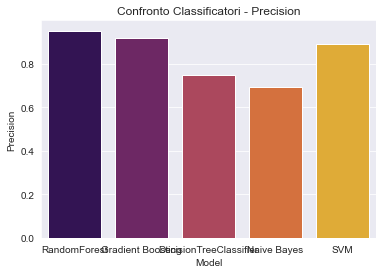

In [435]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Precision'],
                palette = 'inferno').set(title = "Confronto Classificatori - Precision")

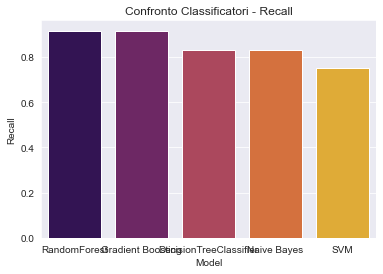

In [439]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Recall'],
                palette = 'inferno').set(title = "Confronto Classificatori - Recall")

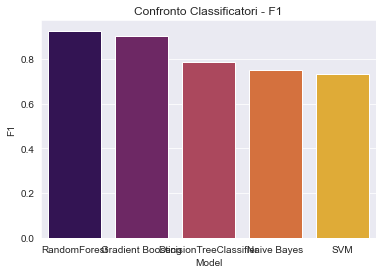

In [436]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['F1'],
                palette = 'inferno').set(title = "Confronto Classificatori - F1")

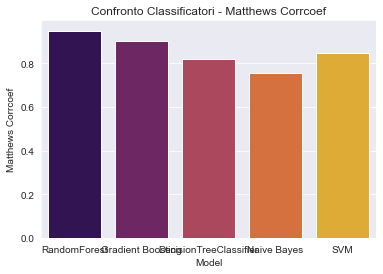

In [437]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Matthews Corrcoef'],
                palette = 'inferno').set(title = "Confronto Classificatori - Matthews Corrcoef")

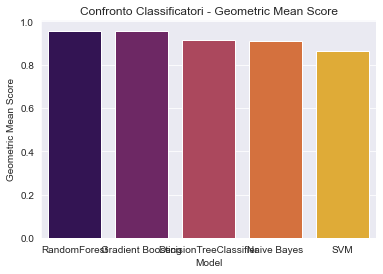

In [438]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Geometric Mean Score'],
                palette = 'inferno').set(title = "Confronto Classificatori - Geometric Mean Score" )

Come si evince dai grafici precedenti il modello migliore è risultato il **Random
Forest**, sebbene nel complesso si siano comportati tutti ottimamente.
Unica eccezione è Gradient Boost, il quale sebbene abbia avuto anche esso degli
ottimi risultati, la fase di apprendimento ha impiegato un quantità risorse(tempo)
eccessiva